In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm, trange

# against matplotlib kernel dieing
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# drive_path = 'drive/My Drive/Colab Notebooks/WP_Datasets_Normalized/'
# Cebrina's   Path: C:\Users\cebri\Documents\Wind Power Estimation\Data
# Guillermo's Path: C:\DTU\\02456 - Deep Learning\Project\Datasets
# Tomi's      Path: C:\Users\PC\Documents\GitHub\WindPower_Estimation

dataPath = r'C:\Users\PC\Documents\GitHub\WindPower_Estimation'

dataset_train_1 = pd.read_csv(dataPath+'\Case1\Dataset_Train_1.csv', )
dataset_test_1 = pd.read_csv(dataPath+'\Case1\Dataset_Test_1.csv')

dataset_train_1.head()

,Date_Time,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air_Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air_Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air_Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air_Density_150m,Park_Power_[KW]
0,2017-01-07 20:15:00,0.476323,0.110000,0.218502,0.782227,0.752212,0.473538,0.127679,0.218502,0.752212,0.484680,0.047716,0.218502,0.752212,0.515320,0.019504,0.218502,0.752212,0.690394
1,2017-01-07 20:30:00,0.479109,0.116923,0.214832,0.781496,0.755162,0.479109,0.135714,0.214832,0.755162,0.473538,0.053299,0.214832,0.755162,0.459610,0.024823,0.214832,0.755162,0.690394
2,2017-01-07 20:45:00,0.481894,0.127692,0.211009,0.780216,0.758112,0.481894,0.147321,0.211009,0.758112,0.462396,0.061421,0.211009,0.758112,0.431755,0.032624,0.211009,0.758112,0.690394
3,2017-01-07 21:00:00,0.484680,0.140769,0.207187,0.778387,0.764012,0.487465,0.161607,0.207187,0.764012,0.459610,0.072589,0.207187,0.764012,0.417827,0.042908,0.207187,0.764012,0.690394
4,2017-01-07 21:15:00,0.487465,0.155385,0.203364,0.776376,0.766962,0.490251,0.178571,0.203364,0.766962,0.456825,0.084772,0.203364,0.766962,0.412256,0.054610,0.203364,0.766962,0.690394


In [2]:
# Any results you write to the current directory are saved as output.
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

In [3]:
train_set = dataset_train_1[['Speed_50m', 'Direction_50m', 'Park_Power_[KW]']]
valid_set = dataset_test_1[['Speed_50m', 'Direction_50m', 'Park_Power_[KW]']]

In [4]:
temp = train_set.to_numpy()
print( temp[2] )

[0.14732143 0.48189415 0.69039401]


In [5]:
def split_sequence(data_x, data_y, seq_length_past, seq_length_future):
    x = []
    y = []

    for i in range(seq_length_past,len(data_x)-seq_length_future):
        _x = data_x[(i-seq_length_past ):(i )]
        _y = data_y[i]
        x.append(_x)
        y.append(_y)

    return np.array(x)  ,np.array(y)

 
seq_length_past = 100
seq_length_future = 1


train_x, train_y   = split_sequence( dataset_train_1[['Speed_50m', 'Direction_50m']].to_numpy(), dataset_train_1[[ 'Park_Power_[KW]']].to_numpy()  , seq_length_past, seq_length_future)
test_x, test_y   = split_sequence( dataset_test_1[['Speed_50m', 'Direction_50m']].to_numpy(), dataset_test_1[[ 'Park_Power_[KW]']].to_numpy()  , seq_length_past, seq_length_future)


# trainX = Variable(torch.Tensor(np.array(x)).cuda())
# trainY = Variable(torch.Tensor(np.array(y)).cuda())
# print( train_x[0] )

In [6]:
class ElecDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [7]:
# jsut for testing purpose 

train = ElecDataset( train_x.reshape(train_x.shape[0],train_x.shape[1],2), train_y)
test = ElecDataset( test_x.reshape(test_x.shape[0],test_x.shape[1],2), test_y)

train_loader = torch.utils.data.DataLoader(train, batch_size=5, shuffle=False )
test_loader = torch.utils.data.DataLoader(test, batch_size=5, shuffle=False )



In [8]:
# print( (seq_length_past-11+1)/2 )   #for maxpool1
# original: seqLength-kernelSize+1


In [9]:
class CNN_ForecastNet(nn.Module):
    def __init__(self, inputChannels, outputChannels, middleChannels, kernelSize1, kernelSize2, seqLength):
        super(CNN_ForecastNet,self).__init__()
        
        self.conv1d_1 = nn.Conv1d(in_channels=inputChannels, out_channels=middleChannels, kernel_size= kernelSize1 ) 
        #output: seqLength-kernelSize1+1 == 100-4+1:97
        self.batchnorm1D_conv1 = nn.BatchNorm1d( middleChannels )  #the nuber of output channels
        
        self.conv1d_2 = nn.Conv1d(in_channels=middleChannels, out_channels=outputChannels, kernel_size= kernelSize2 )
        #output: conv1_seqLength-kernelSize2+1 == 97-8+1 =90
        self.batchnorm1D_conv2 = nn.BatchNorm1d( outputChannels )  #the nuber of output channels
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d( kernel_size=2  ) #kernel size from which teh pooling is selected
        self.dropout = nn.Dropout(p=0.1)
        #output: conv2_seqLength/2 == 90/2:45
        
        self.fc1 = nn.Linear( outputChannels*( int( ((seqLength-kernelSize1+1)-kernelSize2+1)/2 ) ), 1)
        self.fc2 = nn.Linear(50,1)
        self.sigmoid = nn.Sigmoid()
#         self.batchNorm1 = nn.BatchNorm1d(seqLength-kernelSize+1)
        
    def forward(self,x):
#         print( f'data first in network {x.shape}'  )
        x = self.conv1d_1(x)
        x = self.batchnorm1D_conv1(x)
        x = self.relu(x)
#         print(f'data after 1st conv in network {x.shape}')

        x = self.conv1d_2(x)
        x = self.batchnorm1D_conv2(x)
        x = self.relu(x)
        
        x = self.maxpool(x)
        x = self.dropout(x)
        
        x = x.view( x.shape[0], -1)
        x = self.fc1(x)
        x = self.sigmoid(x)
#         x = self.fc2(x)
        
        return x

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inputChannels = 2
outputChannels = 20
middleChannels = 8
kernelSize1 = 4
kernelSize2 = 30
model = CNN_ForecastNet(inputChannels, outputChannels, middleChannels, kernelSize1, kernelSize2, seq_length_past).to(device)



optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [11]:
train = ElecDataset( train_x, train_y)
test = ElecDataset( test_x, test_y)
batchSize = 1000

train_loader = torch.utils.data.DataLoader(train, batch_size=batchSize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batchSize, shuffle=True)
# temp =next( iter( train_loader))
# print( temp )
# print( torch.permute( temp,(0,2,1) ))
# print( next( iter( train_loader)) )

In [12]:
train_losses = []
test_losses = []
def Train():
    running_loss = .0
    model.train()
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = torch.permute( inputs,(0,2,1) )
        inputs = inputs.to( device )
        labels = labels.to( device )
        optimizer.zero_grad()
        preds = model( inputs.float() )
        loss = criterion( preds,labels.float() )
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.cpu().detach().numpy())
    if( len( train_losses)%10 ==0  or  len( train_losses) ==1  ):
        print(f'train_loss {train_loss}')
    

def Valid():
    running_loss = .0
    model.eval()
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = torch.permute( inputs,(0,2,1) )
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        test_loss = running_loss/len(test_loader)
        test_losses.append(test_loss.cpu().detach().numpy())
        
        if( len( test_losses)%10 ==0  or  len( test_losses) ==1 ):
            print(f'test_loss {test_loss}')


In [13]:
epochs = 1000
for epoch in trange((epochs), desc='Number of epochs: '):
#     print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()
    gc.collect()

Number of epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

train_loss 0.1078617200255394
test_loss 0.09598023174812505
train_loss 0.057687871158123016
test_loss 0.05877516876873271
train_loss 0.05330377072095871
test_loss 0.05299566351305198
train_loss 0.051101963967084885
test_loss 0.049525398470480805
train_loss 0.04972924292087555
test_loss 0.048088105922028626
train_loss 0.048693884164094925
test_loss 0.047086137054547665
train_loss 0.047872625291347504
test_loss 0.04599437592898113
train_loss 0.04722600430250168
test_loss 0.04542775923990396
train_loss 0.046501584351062775
test_loss 0.04466097151528436
train_loss 0.04595911130309105
test_loss 0.043765379337139754
train_loss 0.04556985944509506
test_loss 0.04399436546788019
train_loss 0.04511283338069916
test_loss 0.04343607263307493
train_loss 0.04480673372745514
test_loss 0.04318595534718374
train_loss 0.044587768614292145
test_loss 0.042687843034158034
train_loss 0.04443635046482086
test_loss 0.04177739031764688
train_loss 0.04424024745821953
test_loss 0.04183004699697804
train_loss 0.0

KeyboardInterrupt: 

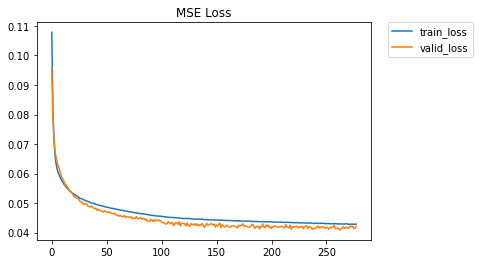

In [14]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
plt.plot(test_losses,label='valid_loss')
plt.title('MSE Loss')
# plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [15]:
train = ElecDataset( train_x, train_y)
test = ElecDataset( test_x, test_y)
batchSize = batchSize

train_loader = torch.utils.data.DataLoader(train, batch_size=batchSize, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batchSize, shuffle=False)
prediction = []
target = []
model.eval()

for i in range(2):
    inputs, labels = next( iter( train_loader))
    inputs = torch.permute( inputs,(0,2,1) )
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    preds = model(inputs.float())
    prediction.append( preds.cpu().detach().numpy() )
    target.append( labels.cpu().detach().numpy() )
    
prediction = list(np.concatenate(prediction).flat)
target = list(np.concatenate(target).flat)

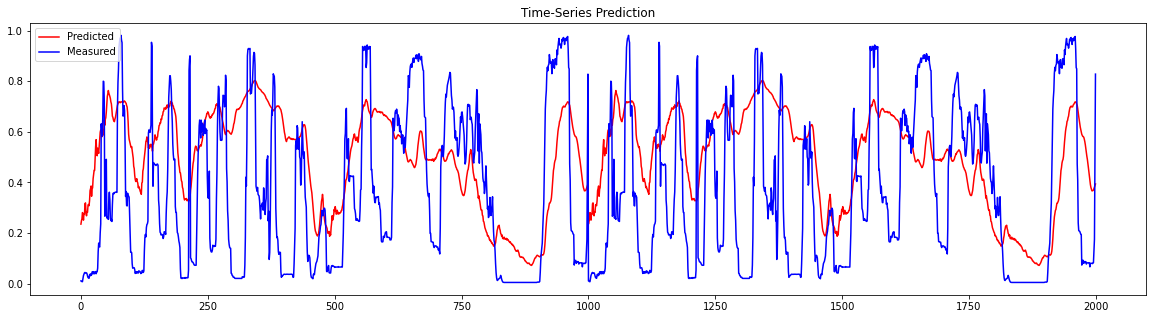

In [16]:
plt.figure(figsize=(20, 5))
plt.plot(prediction, color = 'r', label='Predicted') 
plt.plot(target, color = 'b', label='Measured') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show()